# Plot

> A collection of plot functions

## Setup

In [ ]:
#|default_exp plot

In [ ]:
#| export
import joblib,logomaker
import pandas as pd, numpy as np, seaborn as sns
from adjustText import adjust_text
from pathlib import Path
from tqdm import tqdm
from fastcore.meta import delegates

from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from numpy import trapz


# Katlas
from katlas.feature import *
from katlas.core import *

# Bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, AutocompleteInput, CustomJS
from bokeh.layouts import column
from bokeh.palettes import Category20_20
from itertools import cycle
import math

from sklearn.metrics import pairwise_distances

## Utils

In [ ]:
#| export
def set_sns():
    "Set seaborn resolution for notebook display"
    sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
    sns.set_context('notebook')
    sns.set_style("ticks")

In [ ]:
#| export
def get_color_dict(categories, # list of names to assign color
                   palette: str='tab20', # choose from sns.color_palette
                   ):
    "Assign colors to a list of names (allow duplicates), returns a dictionary of unique name with corresponding color"
    p=sns.color_palette(palette)
    color_cycle = cycle(p)
    color_map = {category: next(color_cycle) for category in categories}
    return color_map

In [ ]:
get_color_dict(['a','a','b'])

{'a': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'b': (1.0, 0.4980392156862745, 0.054901960784313725)}

## Heatmap

In [ ]:
# get kinase-substrate dataset
ks = Data.get_ks_dataset()

In [ ]:
ks_k = ks[ks.kinase_uniprot=='P00519']

In [ ]:
pssm_df = get_prob(ks_k,'site_seq')
pssm_df.head()

Position,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,...,11,12,13,14,15,16,17,18,19,20
aa,,,,,,,,,,,,,,,,,,,,,
P,0.050061,0.048691,0.062349,0.055489,0.046988,0.054753,0.064787,0.055090,0.056683,0.048272,...,0.052728,0.051140,0.069436,0.063164,0.057716,0.056639,0.051072,0.050697,0.052163,0.060703
G,0.080586,0.080341,0.069007,0.067551,0.082530,0.070397,0.093581,0.073054,0.077566,0.072706,...,0.099939,0.070856,0.071916,0.075672,0.071518,0.064821,0.080076,0.088720,0.062341,0.090735
A,0.080586,0.080341,0.062954,0.054282,0.075301,0.071600,0.070186,0.070060,0.065632,0.070322,...,0.064378,0.077634,0.069436,0.072545,0.063363,0.079924,0.088272,0.087452,0.057888,0.070927
C,0.017094,0.012781,0.013317,0.019903,0.012048,0.017449,0.007798,0.014371,0.013126,0.012515,...,0.007357,0.017868,0.014879,0.012508,0.011920,0.018880,0.019546,0.014575,0.019084,0.014058
S,0.047619,0.035910,0.046610,0.030157,0.037349,0.042720,0.041992,0.041916,0.034010,0.039333,...,0.024525,0.036352,0.047117,0.040025,0.042033,0.040277,0.039092,0.051965,0.041349,0.039617


In [ ]:
@delegates(sns.heatmap)
def plot_heatmap_simple(matrix, # a matrix of values
                 title: str='heatmap', # title of the heatmap
                 figsize: tuple=(6,7), # (width, height)
                 cmap: str='binary', # color map, default is dark&white
                 **kwargs, # arguments for sns.heatmap()
                 ):
    
    "Plot heatmap based on a matrix of values"
    
    plt.figure(figsize=figsize)
    sns.heatmap(matrix, square=True,cmap=cmap, annot=False,**kwargs)
    plt.title(title)
    plt.ylabel('')
    plt.xlabel('')
    plt.yticks(rotation=0)

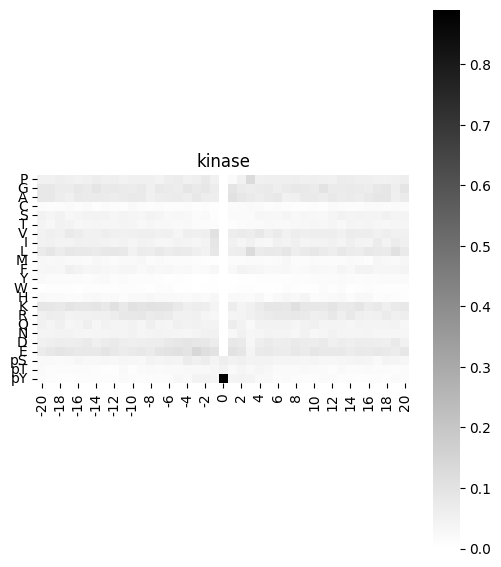

In [ ]:
plot_heatmap_simple(pssm_df,'kinase')

In [ ]:
#| export
def plot_heatmap(heatmap_df, ax=None, position_label=True, figsize=(5, 6), include_zero=True):
    """Plots a heatmap with specific formatting."""
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    mask = np.zeros_like(heatmap_df, dtype=bool)
    zero_position = len(heatmap_df.columns) // 2
    
    if not include_zero:
        mask[:, zero_position] = True  # Mask position 0 if include_zero is False
    
    sns.heatmap(
        heatmap_df,
        cmap='coolwarm',
        center=0,
        linewidth=0.3,
        ax=ax,
        mask=mask  # Apply mask conditionally
    )
    
    # Access and format the color bar
    colorbar = ax.collections[0].colorbar
    colorbar.ax.set_title("Prob.", loc='center')
    
    # Add vertical lines
    ax.axvline(zero_position, color='black', linewidth=0.5)
    ax.axvline(math.ceil(len(heatmap_df.columns) / 2), color='black', linewidth=0.5)
    
    # Format the heatmap border
    ax.patch.set_edgecolor("black")
    ax.patch.set_linewidth(1.5)

    # Hide axis labels
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.xaxis.set_ticks_position('top')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    if not position_label:
        ax.set_xticklabels([])

    return ax

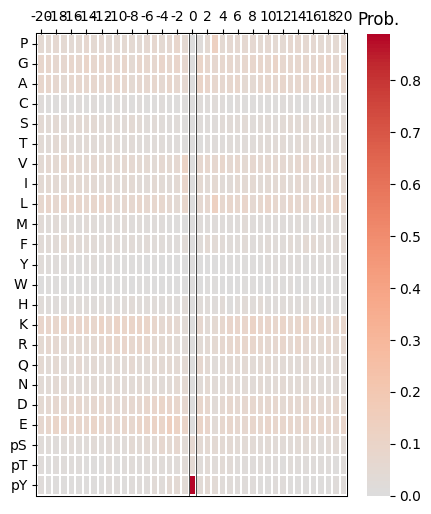

In [ ]:
plot_heatmap(pssm_df);
# plt.savefig('plot.svg',bbox_inches='tight')

## Logo

### From frequency data

In [ ]:
#| export
def change_center_name(df):
    "Transfer the middle pS,pT,pY to S,T,Y for plot."
    df=df.copy()
    
    df.loc['S', 0] = df.loc['pS', 0]
    df.loc['T', 0] = df.loc['pT', 0]
    df.loc['Y', 0] = df.loc['pY', 0]
    df.loc[['pS', 'pT', 'pY'], 0] = 0
    return df

In [ ]:
#| export
def scale_zero_position(logo_df):
    logo_df = logo_df.copy()
    m = logo_df.sum()[logo_df.sum().index!=0].max()
    logo_df[0] = m*(logo_df[0]/logo_df[0].sum())
    return logo_df

In [ ]:
#| export
def get_logo_df(prob_df,scale_zero=True):
    logo_df = get_scaled_IC(prob_df)
    logo_df = change_center_name(logo_df)
    total_IC = logo_df.sum().sum().round(2)
    if scale_zero:
        logo_df = scale_zero_position(logo_df)
    return logo_df,total_IC

In [ ]:
#| export
def plot_logo(prob_df,title='Motif', scale_zero=True,ax=None,figsize=(6,1)):
    logo_df,total_IC = get_logo_df(prob_df,scale_zero=scale_zero)
        
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    logo = logomaker.Logo(logo_df.T, color_scheme='kinase_protein', flip_below=False, ax=ax)
    logo.ax.set_ylabel("Info (bits)")
    logo.style_xticks(fmt='%d')
    ax.set_title(f'{title}')

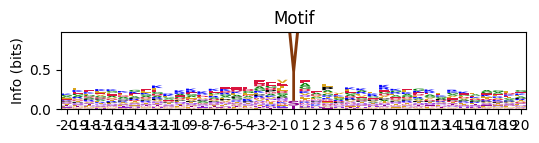

In [ ]:
plot_logo(pssm_df,scale_zero=False)

Set scale_zero to default True can have better vision of the side amino acids

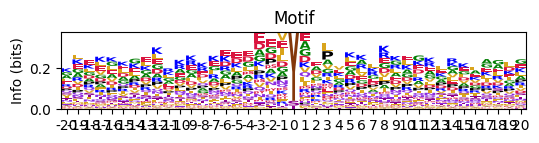

In [ ]:
plot_logo(pssm_df)

In [ ]:
#| export
def extract_motifs(df, cluster_col, seq_col='site_seq', count_thr=10, valid_thr=None,plot=False):
    "Extract motifs from clusters in a dataframe"
    pssms = []
    ids = []
    value_counts = df[cluster_col].value_counts()
    for cluster_id, counts in tqdm(value_counts.items(),total=len(value_counts)):
        if count_thr is not None and counts <= count_thr:
            continue

        df_cluster = df[df[cluster_col] == cluster_id]
        pssm = get_prob(df_cluster, seq_col)
        valid_score = (pssm != 0).sum().sum() / (pssm.shape[0] * pssm.shape[1])

        if valid_thr is not None and valid_score <= valid_thr:
            continue

        pssms.append(flatten_pssm(pssm))
        ids.append(cluster_id)

        if plot:
            plot_logo(pssm, title=f'Cluster {cluster_id} (n={counts})', figsize=(14, 1))
            plt.show()
            plt.close()

    pssm_df = pd.DataFrame(pssms, index=ids)
    return pssm_df

In [ ]:
#| export
def plot_logo_heatmap(pssm_df, # column is position, index is aa
                       title='Motif',
                       figsize=(7,8),
                       include_zero=False
                      ):
    
    """Plot logo and heatmap vertically"""
    
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 5], width_ratios=[4, 1], hspace=0.11, wspace=0)

    ax_logo = fig.add_subplot(gs[0, 0])
    plot_logo(pssm_df,ax=ax_logo,title=title)

    ax_heatmap = fig.add_subplot(gs[1, :])
    plot_heatmap(pssm_df,ax=ax_heatmap,position_label=False,include_zero=include_zero)

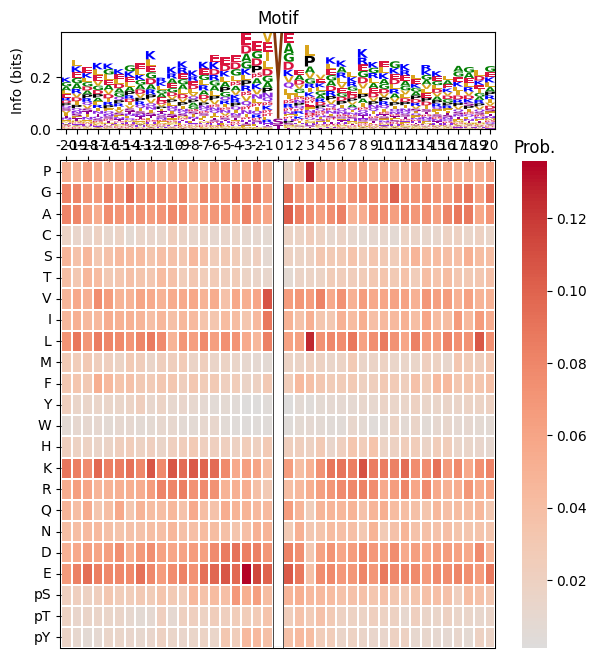

In [ ]:
plot_logo_heatmap(pssm_df)

### Plot PSPA data logo

In [ ]:
#| export
def plot_logo_raw(logo_df,ax=None,title='Motif',ytitle='Enrichment',figsize=(6,2)):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    logo = logomaker.Logo(logo_df.T, color_scheme='kinase_protein', flip_below=False, ax=ax)
    logo.ax.set_ylabel(ytitle)
    logo.style_xticks(fmt='%d')
    ax.set_title(title)

In [ ]:
#| export
def get_logo(df: pd.DataFrame, # stacked Dataframe with kinase as index, substrates as columns
             kinase: str, # a specific kinase name in index
             ):
    "Given stacked df (index as kinase, columns as substrates), get a specific kinase's logo"
    
    
    # get raw kinase to calculate S/T
    pp = get_one_kinase(df,kinase,normalize=False)
    
    # get S/T ratio value
    ss = pp['S'].sum()
    st = pp['T'].sum()

    S_ctrl = 0.75*ss - 0.25*st
    T_ctrl = 0.75*st - 0.25*ss

    S0 = S_ctrl / max(S_ctrl, T_ctrl)
    T0 = T_ctrl / max(S_ctrl, T_ctrl)

    S_ratio = S0/(S0+T0)
    T_ratio = T0/(S0+T0)
    
    # get normalized kinase
    norm_p = get_one_kinase(df,kinase, normalize=True)
    
    # calculate ratio, divide values by median, followed by log2 transformation
    ratio =norm_p.apply(lambda r: r/r.median(),axis=1)
    ratio = np.log2(ratio)

    m = ratio.apply(lambda row: row[row > 0].sum(), axis=1).max()

    new_row = pd.DataFrame({'S': S_ratio*m, 'T':T_ratio*m}, index=[0]) 

    ratio2 = pd.concat([ratio, new_row], ignore_index=False).fillna(0)
    
    # plot logo
    # logo_func(ratio2, kinase)
    plot_logo_raw(ratio2.T,title=kinase)

This function is to replicate the motif logo from [Johnson et al. Nature: An atlas of substrate specificities for the human serine/threonine kinome](https://www.nature.com/articles/s41586-022-05575-3). Given raw PSPA data, it can output a motif logo.

In [ ]:
# load raw PSPA data
df = pd.read_csv('https://github.com/sky1ove/katlas_raw/raw/refs/heads/main/nbs/raw/pspa_st_raw.csv').set_index('kinase')
df.head()

,-5P,-5G,-5A,-5C,-5S,-5T,-5V,-5I,-5L,-5M,...,4H,4K,4R,4Q,4N,4D,4E,4s,4t,4y
kinase,,,,,,,,,,,,,,,,,,,,,
AAK1,7614134.38,2590563.43,3001315.49,4696631.43,4944311.77,8315837.72,10056545.00,16433061.43,10499735.53,9133577.86,...,6020662.73,8938081.41,9983402.01,6833481.55,6364453.29,4189045.89,4921595.57,2705053.53,2705053.53,2909279.71
ACVR2A,4991039.28,5783855.86,7015770.78,8367603.09,7072052.48,7601399.57,7188292.41,7513915.73,7159894.71,6266122.81,...,6039472.76,5556300.56,5178734.62,6490097.70,5862480.97,6742905.78,6750653.36,7414220.16,7414220.16,6209576.97
ACVR2B,26480329.10,25689687.16,28137300.90,45175909.30,32876722.90,33516959.03,27011194.06,21996255.94,23412987.54,25670581.40,...,27984195.21,22496915.32,24236904.72,29132857.30,26527389.14,36388726.15,34729319.54,37906081.09,37906081.09,31761418.56
AKT1,18399509.29,18104681.05,16831835.48,17247743.90,22647275.57,17801288.32,13037570.99,13271896.32,14156489.52,15409761.84,...,29511541.69,50942663.29,48152924.11,32693882.62,28896602.57,19701350.30,13887460.52,17483074.60,17483074.60,11696833.54
AKT2,5439237.54,5569477.23,5805462.70,6301076.01,5004932.12,4812022.80,3906822.27,3776845.45,4450344.85,4629319.80,...,6812201.58,11590683.50,9932525.89,6544476.93,6252360.75,3629091.99,3510048.19,5499662.30,5499662.30,4188620.88


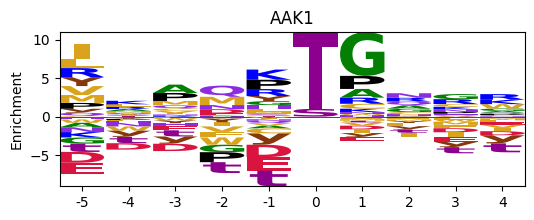

In [ ]:
# plot logo of a kinase
get_logo(df, 'AAK1')

## Rank

In [ ]:
#| export
@delegates(sns.scatterplot)
def plot_rank(sorted_df: pd.DataFrame, # a sorted dataframe
              x: str, # column name for x axis
              y: str, # column name for y aixs
              n_hi: int=10, # if not None, show the head n names
              n_lo: int=10, # if not None, show the tail n names
              figsize: tuple=(10,8), # figure size
              **kwargs # arguments for sns.scatterplot()
              ):
    
    "Plot rank from a sorted dataframe"

    plt.figure(figsize=figsize)
    
    sorted_df = sorted_df.reset_index(drop=True) # drop customized index
    
    sns_plot = sns.scatterplot(data=sorted_df, 
                               x = x,
                               y = y, **kwargs)

    sns_plot.set_xticks([])
    
    
    texts = []
    
    # Annotate the highest n values
    if n_hi is not None:
        
        for i, row in sorted_df.head(n_hi).iterrows():
            texts.append(plt.text(i, row[y], row[x], ha='center', va='bottom'))

    if n_lo is not None:
        # Annotate the lowest n values
        n_lowest = n_lo
        for i, row in sorted_df.tail(n_lowest).iterrows():
            texts.append(plt.text(i, row[y], row[x], ha='center', va='bottom'))
            
    if len(texts)>0:
        # Use adjustText to adjust text positions
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))

    plt.tight_layout()

In [ ]:
# load data
# df = Data.get_pspa_raw().set_index('kinase')
df = pd.read_csv('https://github.com/sky1ove/katlas_raw/raw/refs/heads/main/nbs/raw/pspa_st_raw.csv').set_index('kinase')


# get sorted dataframe
sorted_df = df.max(1).reset_index(name='values').sort_values('values')
sorted_df.head()

,kinase,values
68,CK1G2,189898.392
294,VRK2,4191709.640
8,ALPHAK3,4573611.730
249,PRPK,8495330.790
38,CAMLCK,9413689.600


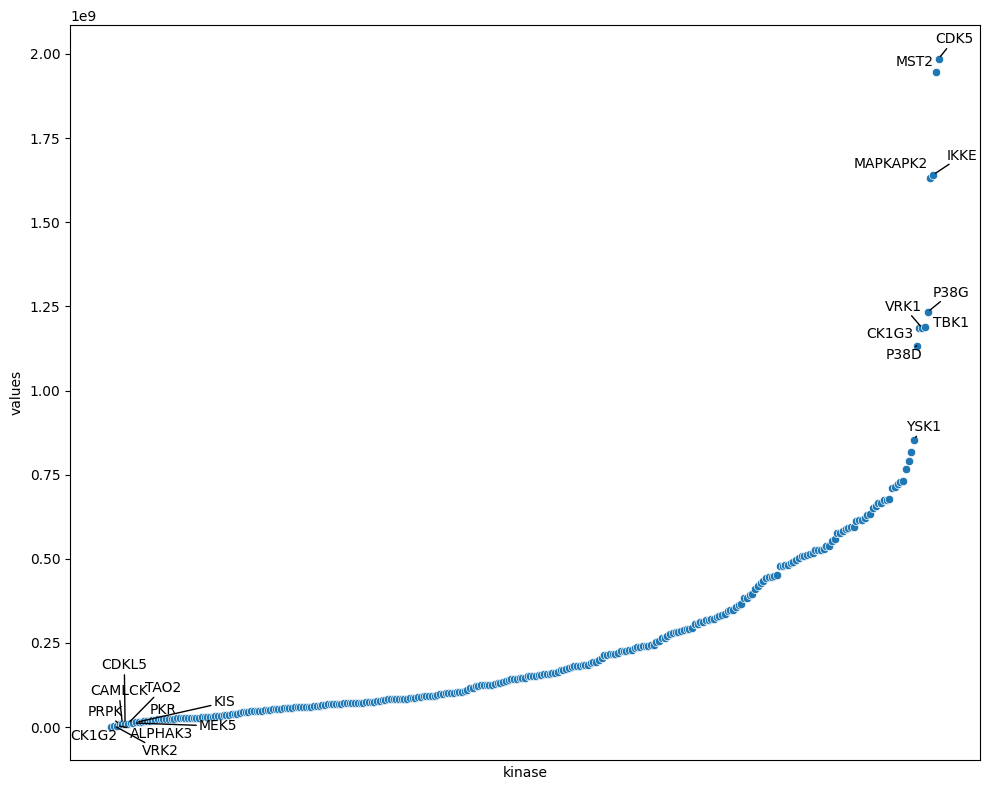

In [ ]:
plot_rank(sorted_df,x='kinase',y='values')
plt.xlabel('kinase');

## Distribution histogram

In [ ]:
#| export
@delegates(sns.histplot)
def plot_hist(df: pd.DataFrame, # a dataframe that contain values for plot
              x: str, # column name of values
              figsize: tuple=(6,2),
              **kwargs, # arguments for sns.histplot()
             ):
    
    hist_params = {'element':'poly',
              'edgecolor': None,
              'alpha':0.5,
              'bins':100,
              'kde':True}
    
    plt.figure(figsize=figsize)
    sns.histplot(data=df,x=x,**hist_params,**kwargs)

In [ ]:
# we can use the same df
sorted_df.head()

,kinase,values
68,CK1G2,189898.392
294,VRK2,4191709.640
8,ALPHAK3,4573611.730
249,PRPK,8495330.790
38,CAMLCK,9413689.600


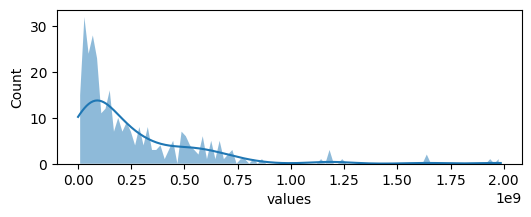

In [ ]:
plot_hist(sorted_df,'values')

## Scatter plot

In [ ]:
#| export
@delegates(sns.scatterplot)
def plot_2d(X: pd.DataFrame, # a dataframe that has first column to be x, and second column to be y
            **kwargs, # arguments for sns.scatterplot
            ):
    "Make 2D plot from a dataframe that has first column to be x, and second column to be y"
    plt.figure(figsize=(7,7))
    sns.scatterplot(data = X,x=X.columns[0],y=X.columns[1],alpha=0.7,**kwargs)

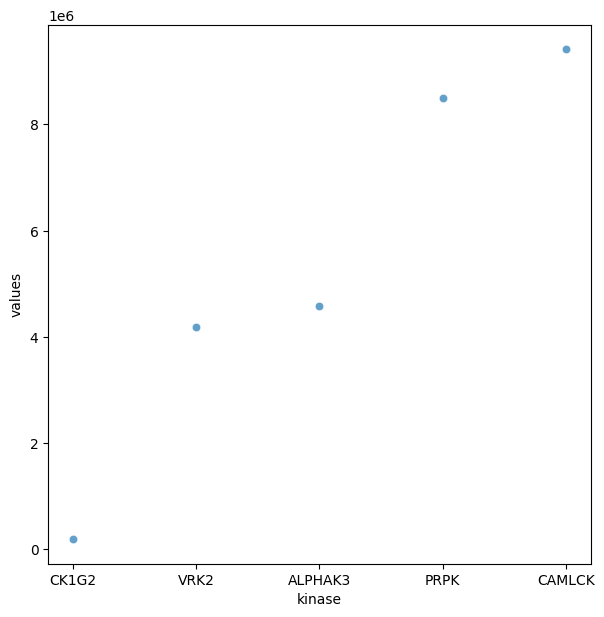

In [ ]:
plot_2d(_.iloc[:,:2])

## Dimension reduction - 2d plot

In [ ]:
#| export
def plot_cluster(
    df: pd.DataFrame,  # a dataframe of values that is waited for dimensionality reduction
    method: str = 'pca',  # dimensionality reduction method, choose from pca, umap, and tsne
    hue: str = None,  # colname of color
    complexity: int = 30,  # recommend 30 for tsne, 15 for umap, none for pca
    palette: str = 'tab20',  # color scheme, could be tab10 if less categories
    legend: bool = False,  # whether or not add the legend on the side
    name_list=None,  # a list of names to annotate each dot in the plot
    seed: int = 123,  # seed for dimensionality reduction
    s: int = 50,  # size of the dot
    **kwargs  # arguments for dimensional reduction method to be used
):
    """
    Given a dataframe of values, plot it in 2D. 
    The method could be 'pca', 'tsne', or 'umap'.
    """
    
    embedding_df = reduce_feature(df, method=method, seed=seed, complexity=complexity, **kwargs)
    x_col, y_col = embedding_df.columns 
    
    sns.relplot(
        data=embedding_df, x=x_col, y=y_col, hue=hue, palette=palette, s=s, alpha=0.8, legend=legend
    )
    plt.xticks([])
    plt.yticks([])
    
    if name_list is not None:
        texts = [
            plt.text(
                embedding_df[x_col].iloc[i], embedding_df[y_col].iloc[i], str(name_list[i]), fontsize=8
            ) for i in range(len(embedding_df))
        ]
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))
    
    plt.show()

In [ ]:
# load data
aa = Data.get_aa_info()
aa_rdkit = get_rdkit_df(aa, 'SMILES') # get rdkit features from SMILES columns
aa_rdkit = preprocess(aa_rdkit) # remove similar columns
info=Data.get_aa_info()

removing columns: {'fr_C_S', 'fr_lactam', 'SlogP_VSA7', 'fr_Nhpyrrole', 'fr_pyridine', 'fr_benzene', 'SlogP_VSA10', 'fr_ketone_Topliss', 'fr_dihydropyridine', 'fr_nitro', 'NumSaturatedCarbocycles', 'fr_C_O_noCOO', 'fr_oxime', 'fr_thiazole', 'fr_Ar_COO', 'fr_Imine', 'fr_urea', 'PEOE_VSA13', 'fr_furan', 'fr_ketone', 'SlogP_VSA9', 'PMI3', 'fr_aniline', 'fr_isothiocyan', 'fr_guanido', 'fr_piperdine', 'fr_ether', 'fr_Ndealkylation1', 'fr_nitrile', 'HeavyAtomCount', 'fr_phos_ester', 'fr_azo', 'fr_diazo', 'MaxPartialCharge', 'fr_prisulfonamd', 'fr_methoxy', 'fr_nitroso', 'Eccentricity', 'fr_nitro_arom', 'fr_piperzine', 'fr_quatN', 'fr_phenol', 'Chi0', 'SMR_VSA2', 'fr_HOCCN', 'PEOE_VSA5', 'fr_isocyan', 'fr_Ar_NH', 'NumAliphaticCarbocycles', 'fr_amidine', 'fr_ester', 'fr_Al_OH_noTert', 'fr_term_acetylene', 'fr_ArN', 'BCUT2D_MRHI', 'fr_amide', 'NumAliphaticRings', 'fr_barbitur', 'fr_Ar_OH', 'fr_alkyl_halide', 'fr_azide', 'LabuteASA', 'fr_hdrzone', 'fr_nitro_arom_nonortho', 'fr_aldehyde', 'fr_bic

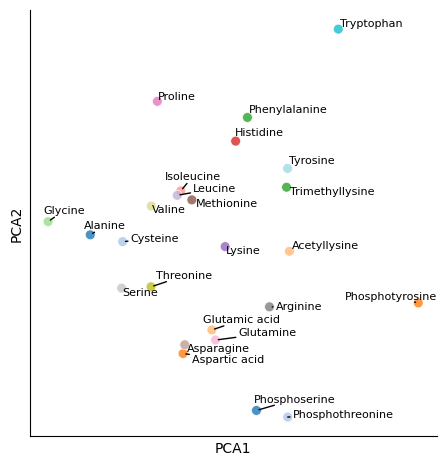

In [ ]:
plot_cluster(aa_rdkit, name_list = aa.Name.tolist(), hue = 'aa')

## Bokeh interactive plot

In [ ]:
#| export
def plot_bokeh(X:pd.DataFrame, # a dataframe of two columns from dimensionality reduction
               idx, # pd.Series or list that indicates identities for searching box
               hue:None, # pd.Series or list that indicates category for each sample
               s: int=3, # dot size
               **kwargs # key:args format for information to include in the dot information box
               ):
    
    "Make interactive 2D plot with a searching box and window of dot information when pointing "
        
    output_notebook()
    
    idx = list(idx)
    hue = list(hue)
    
    def assign_colors(categories, palette):
        "assign each unique name in a list with a color, returns a color list of same length"
        color_cycle = cycle(palette)
        color_map = {category: next(color_cycle) for category in categories}
        return [color_map[category] for category in categories]
    
    if hue is not None:
        colors  = assign_colors(hue, Category20_20) 
    else:
        colors = ['navy'] * len(X)
    
    data_dict={
    'x': X.iloc[:,0],
    'y': X.iloc[:,1],
    'identity': idx,
    'color': colors,
    'original_color': colors,
    'size': [s] * len(X), 
    'highlighted': ['no'] * len(X)  # To keep track of which dot is highlighted
    }
    
    for key, value in kwargs.items():
        data_dict[key] = value
    
    source = ColumnDataSource(data=data_dict)
    
    p = figure(tools="pan,box_zoom,wheel_zoom,reset")
    p.scatter('x', 'y', source=source, alpha=0.6, color='color', size='size')

    # Disable grid lines
    p.xgrid.visible = False
    p.ygrid.visible = False
    
    # Add hover tool
    hover = HoverTool()
    
    tooltips = [("Identity", "@identity")]

    for key in kwargs.keys():
        tooltips.append((key.capitalize(), f"@{key}"))

    
    hover.tooltips = tooltips
    p.add_tools(hover)
    
    
    autocomplete = AutocompleteInput(title="Search by Identity:", completions=idx)

    callback = CustomJS(args=dict(source=source, plot=p), code="""
        const data = source.data;
        const search_val = cb_obj.value.toLowerCase();
        const x = data['x'];
        const y = data['y'];
        const identity = data['identity'];
        const color = data['color'];
        const original_color = data['original_color'];
        const size = data['size'];
        const highlighted = data['highlighted'];

        for (let i = 0; i < identity.length; i++) {
            if (highlighted[i] === 'yes') {
                color[i] = original_color[i];
                size[i] = 10;
                highlighted[i] = 'no';
            }
            if (identity[i].toLowerCase() === search_val) {
                plot.x_range.start = x[i] - 5;
                plot.x_range.end = x[i] + 5;
                plot.y_range.start = y[i] - 5;
                plot.y_range.end = y[i] + 5;
                color[i] = 'red';
                size[i] = 15;
                highlighted[i] = 'yes';
            }
        }
        source.change.emit();
    """)
    autocomplete.js_on_change('value', callback)

    # Show layout
    layout = column(autocomplete, p)
    show(layout)

In [ ]:
# PCA reduce dimension to 2
X = reduce_feature(aa_rdkit)

# get info
info=Data.get_aa_info()

#plot
plot_bokeh(X, 
           idx = info.Name,
           hue = info.Name,
           s=7, 
           smiles = info.SMILES)

Loading BokehJS ...

## Bar graph

In [ ]:
#| export
def plot_count(cnt, # from df['x'].value_counts()
               tick_spacing: float= None, # tick spacing for x axis
               palette: str='tab20'):
    
    "Make bar plot from df['x'].value_counts()"

    cnt = cnt.sort_values(ascending=True).copy()
    
    c = sns.color_palette(palette)
    ax = cnt.plot.barh(color = c)
    ax.set_ylabel("")

    for index, value in enumerate(cnt):
        plt.text(value, index, str(value),fontsize=10,rotation=-90, va='center')
        # Set x-ticks at regular intervals
    if tick_spacing is not None:
        ax.xaxis.set_major_locator(MultipleLocator(tick_spacing))

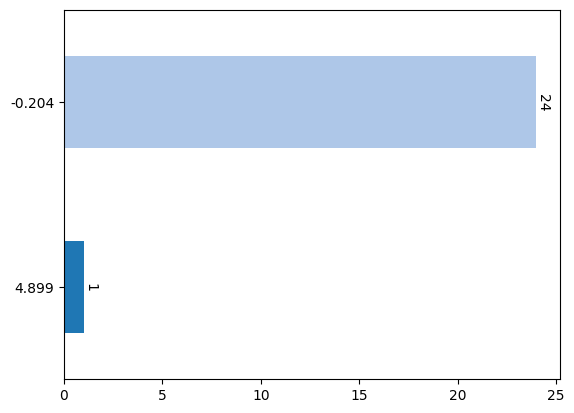

In [ ]:
# get count
cnt = aa_rdkit.fr_sulfide.round(3).value_counts()

# make plot
plot_count(cnt)

In [ ]:
#| export
@delegates(sns.barplot)
def plot_bar(df, 
             value, # colname of value
             group, # colname of group
             title = None,
             figsize = (12,5),
             fontsize=14,
             dots = True, # whether or not add dots in the graph
             rotation=90,
             ascending=False,
             **kwargs
              ):
    
    "Plot bar graph from unstacked dataframe; need to indicate columns of values and categories"
    
    plt.figure(figsize=figsize)
    
    idx = df.groupby(group)[value].mean().sort_values(ascending=ascending).index
    
    sns.barplot(data=df, x=group, y=value, order=idx,hue=group, legend=False, **kwargs)
    
    if dots:
        marker = {'marker': 'o', 
                  'color': 'white', 
                  'edgecolor': 'black', 
                  'linewidth': 1.5, 
                  'jitter':True,
                  's': 5}

        sns.stripplot(data=df, 
                      x=group, 
                      y=value,
                      order=idx,
                      alpha=0.8,
                      # ax=g.ax,
                      **marker)
        
    # Increase font size for the x-axis and y-axis tick labels
    plt.tick_params(axis='x', labelsize=fontsize)  # Increase x-axis label size
    plt.tick_params(axis='y', labelsize=fontsize)  # Increase y-axis label size
    
    # Modify x and y label and increase font size
    plt.xlabel('', fontsize=fontsize)
    plt.ylabel(value, fontsize=fontsize)
    
    # Rotate X labels
    plt.xticks(rotation=rotation)
    
    # Plot titles
    if title is not None:
        plt.title(title,fontsize=fontsize)
    
    plt.gca().spines[['right', 'top']].set_visible(False)

In [ ]:
info['cat'] = (info.pKa1>2).astype(int)

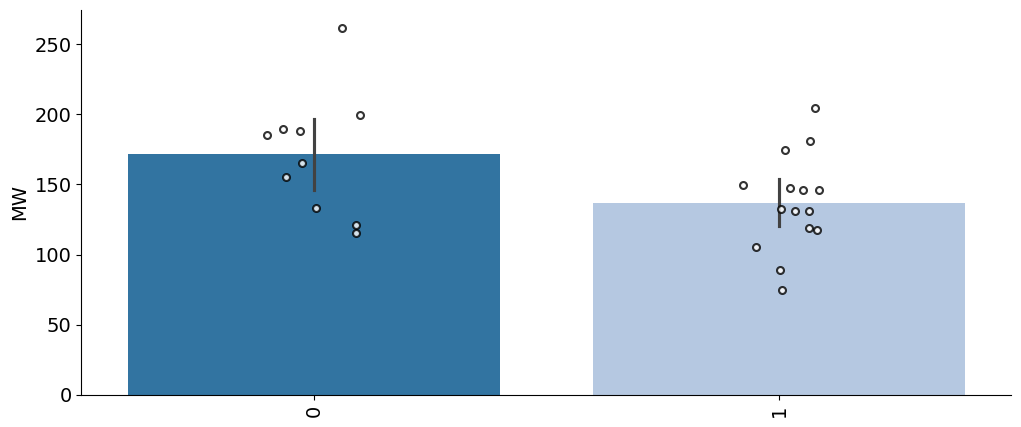

In [ ]:
# get an unstacked dataframe
plot_bar(info,value='MW',group='cat',palette='tab20')

In [ ]:
#| export
@delegates(sns.barplot)
def plot_group_bar(df, 
                   value_cols,  # list of column names for values, the order depends on the first item
                   group,       # column name of group (e.g., 'kinase')
                   figsize=(12, 5),
                   order=None,
                   title=None,
                   fontsize=14,
                   rotation=90,
                   **kwargs):
    
    " Plot grouped bar graph from dataframe. "

    # Prepare the dataframe for plotting
    # Melt the dataframe to go from wide to long format
    df_melted = df.melt(id_vars=group, value_vars=value_cols, var_name='Ranking', value_name='Value')

    plt.figure(figsize=figsize)
    
    # Create the bar plot
    sns.barplot(data=df_melted, 
                x=group, 
                y='Value', 
                hue='Ranking', 
                order=order, 
                capsize=0.1,
                err_kws={'linewidth': 1.5,'color': 'gray'}, 
                **kwargs)
    
    # Increase font size for the x-axis and y-axis tick labels
    plt.tick_params(axis='x', labelsize=fontsize)  # Increase x-axis label size
    plt.tick_params(axis='y', labelsize=fontsize)  # Increase y-axis label size
    
    # Modify x and y label and increase font size
    plt.xlabel('', fontsize=fontsize)
    plt.ylabel('Value', fontsize=fontsize)
    
    # Rotate X labels
    plt.xticks(rotation=rotation)
    
    # Plot titles
    if title is not None:
        plt.title(title, fontsize=fontsize)
    
    plt.gca().spines[['right', 'top']].set_visible(False)
    plt.legend(fontsize=fontsize) # if change legend location, use loc='upper right'

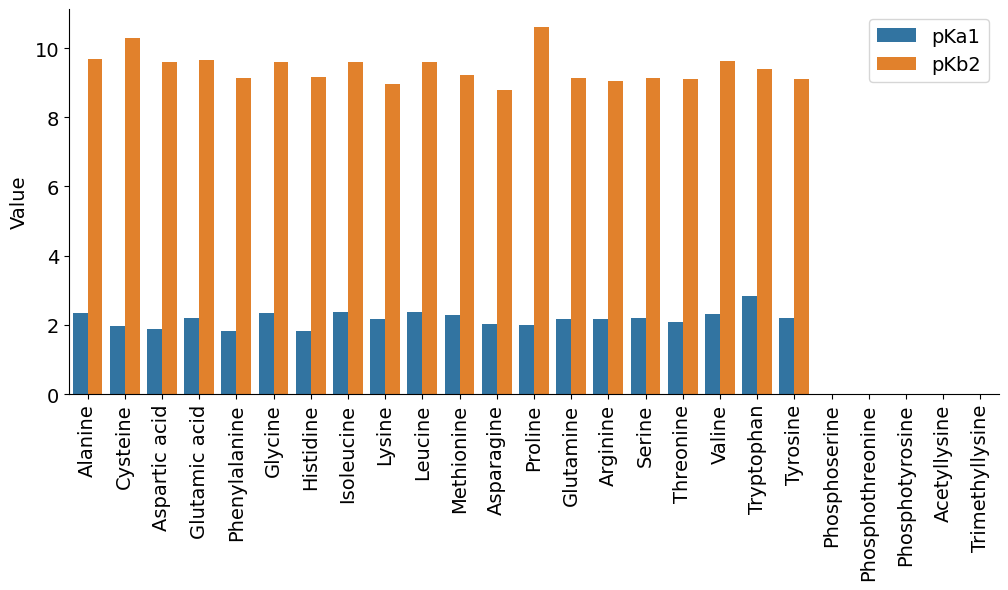

In [ ]:
plot_group_bar(info,['pKa1','pKb2'],'Name')

## Box plot

In [ ]:
#| export
@delegates(sns.boxplot)
def plot_box(df,
             value, # colname of value
             group, # colname of group
             title=None, 
             figsize=(6,3),
             fontsize=14,
             dots=True, 
             rotation=90,
             **kwargs
            ):
    
    "Plot box plot."
    
    plt.figure(figsize=figsize)
    
    idx = df[[group,value]].groupby(group).median().sort_values(value,ascending=False).index
    
    
    sns.boxplot(data=df, x=group, y=value, order=idx,hue=group, legend=False, **kwargs)
    
    if dots:
        sns.stripplot(x=group, y=value, data=df, order=idx, jitter=True, color='black', size=3)
        

    # Increase font size for the x-axis and y-axis tick labels
    plt.tick_params(axis='x', labelsize=fontsize)  # Increase x-axis label size
    plt.tick_params(axis='y', labelsize=fontsize)  # Increase y-axis label size

    plt.xlabel('', fontsize=fontsize)
    plt.ylabel(value, fontsize=fontsize)

    plt.xticks(rotation=rotation)
    
    if title is not None:
        plt.title(title,fontsize=fontsize)
    
    # Remove right and top spines 
    # plt.gca().spines[['right', 'top']].set_visible(False)
    

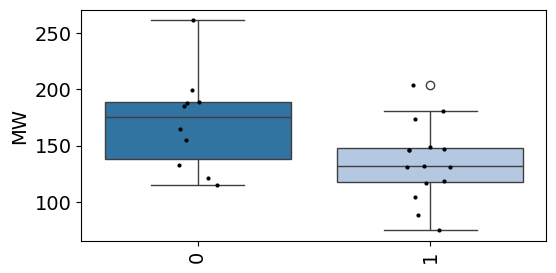

In [ ]:
plot_box(info,value='MW',group='cat',palette='tab20')

## Pearson correlation

In [ ]:
#| export
@delegates(sns.regplot)
def plot_corr(x, # x axis values, or colname of x axis
              y, # y axis values, or colname of y axis
              xlabel=None,# x axis label
              ylabel=None,# y axis label
              data = None, # dataframe that contains data
              text_location = [0.8,0.1],
              **kwargs
              ):
    "Given a dataframe and the name of two columns, plot the two columns' correlation"
    if data is not None:
        x=data[x]
        y=data[y]
        
    pear, pvalue = pearsonr(x, y)
        
    sns.regplot(
                x=x,
                y=y,
                line_kws={'color': 'gray'}, **kwargs
           )
    
    if xlabel is not None:
        plt.xlabel(xlabel)
        
    if ylabel is not None:
        plt.ylabel(ylabel)
    
    # correlation_text = f'Spearman: {correlation:.2f}' if method == 'spearman' else f'Pearson: {correlation:.2f}'

    # plt.text(x=0.8, y=0.1, s=correlation_text, transform=plt.gca().transAxes, ha='center', va='center')
    plt.text(s=f'Pearson = {round(pear,2)}\n   p = {"{:.2e}".format(pvalue)}',
             x=text_location[0],y=text_location[1],
            transform=plt.gca().transAxes, 
             ha='center', va='center')

In [ ]:
norm = Data.get_pspa_st_norm().iloc[:,:-6].T

norm.head()

kinase,AAK1,ACVR2A,ACVR2B,AKT1,AKT2,AKT3,ALK2,ALK4,ALPHAK3,AMPKA1,...,VRK1,VRK2,WNK1,WNK3,WNK4,YANK2,YANK3,YSK1,YSK4,ZAK
-5P,0.0720,0.0415,0.0533,0.0603,0.0602,0.0705,0.0536,0.0552,0.0571,0.0555,...,0.0710,0.0684,0.0482,0.0413,0.0369,0.0580,0.0625,0.0590,0.0593,0.0604
-5G,0.0245,0.0481,0.0517,0.0594,0.0617,0.0624,0.0659,0.0574,0.0478,0.0504,...,0.0786,0.0676,0.0510,0.0572,0.0523,0.0699,0.0776,0.0713,0.0728,0.0641
-5A,0.0284,0.0584,0.0566,0.0552,0.0643,0.0745,0.0662,0.0605,0.0253,0.0534,...,0.0633,0.0636,0.0555,0.0503,0.0539,0.0637,0.0647,0.0731,0.0744,0.0659
-5C,0.0456,0.0489,0.0772,0.0605,0.0582,0.0628,0.0762,0.0483,0.0384,0.0588,...,0.0641,0.0644,0.0576,0.0732,0.0544,0.0602,0.0598,0.0606,0.0734,0.0631
-5S,0.0425,0.0578,0.0533,0.0516,0.0534,0.0442,0.0567,0.0574,0.0571,0.0504,...,0.0595,0.0573,0.0561,0.0569,0.0580,0.0580,0.0545,0.0542,0.0597,0.0597


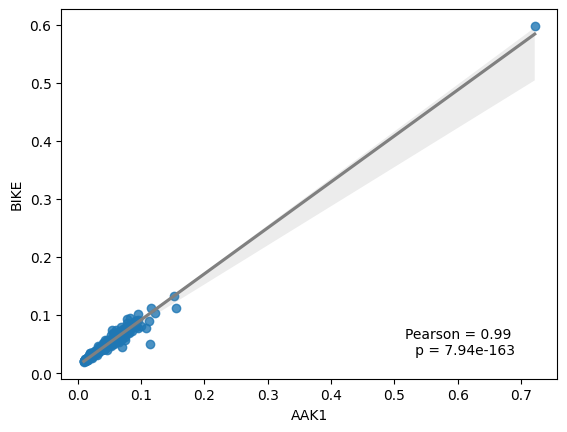

In [ ]:
plot_corr(data=norm, x='AAK1', y='BIKE')

## Matrix heatmap

In [ ]:
#| export
def get_similarity(df, metric='euclidean'):
    "Calculate distance matrix of a df; also return inverse df (similarity df)"
    dist_matrix = pairwise_distances(df, metric=metric)
    dist_df = pd.DataFrame(dist_matrix, index=df.index, columns=df.index)
    
    sigma = np.mean(dist_matrix)
    sim_df = np.exp(-dist_df**2 / (2 * sigma**2))
    return dist_df, sim_df

In [ ]:
#| export
def plot_matrix(dist_matrix, inverse_color=False):
    "Plot distance/similarity matrix"
    
    mask = np.triu(np.ones_like(dist_matrix, dtype=bool))
    cmap = 'coolwarm' if not inverse_color else 'coolwarm_r'
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        dist_matrix,
        cmap=cmap,
        mask=mask,
        # annot=False,
        # fmt='.2f',
        linewidths=0.1,  
        linecolor='white' 
    )
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks(rotation=0)

In [ ]:
rdkit_corr = aa_rdkit.T.corr()
rdkit_corr.head()

aa,A,C,D,E,F,G,H,I,K,L,...,S,T,V,W,Y,s,t,y,Kac,Kme3
aa,,,,,,,,,,,,,,,,,,,,,
A,1.000000,0.362285,0.090512,-0.112693,-0.189588,0.725605,0.000479,0.189212,-0.099613,0.270430,...,0.560214,0.377420,0.294869,-0.345882,-0.292322,-0.257989,-0.294085,-0.540545,-0.446649,-0.353592
C,0.362285,1.000000,-0.064188,-0.173111,-0.249098,0.409469,0.009036,0.008175,-0.245936,-0.027502,...,0.298754,0.143817,0.101138,-0.221078,-0.274137,-0.039459,-0.154141,-0.339660,-0.297758,-0.210207
D,0.090512,-0.064188,1.000000,0.803788,-0.305487,0.065810,-0.211706,-0.272792,-0.229956,-0.263288,...,0.302876,0.228545,-0.181244,-0.340342,-0.191931,0.386431,0.295387,-0.044046,-0.131867,-0.231809
E,-0.112693,-0.173111,0.803788,1.000000,-0.242507,-0.068794,-0.239756,-0.210293,-0.106431,-0.265852,...,0.042331,-0.043214,-0.171171,-0.251833,-0.049223,0.241647,0.166818,0.097376,0.125016,-0.177356
F,-0.189588,-0.249098,-0.305487,-0.242507,1.000000,-0.155484,0.011415,0.093393,0.019161,0.109600,...,-0.352333,-0.328142,-0.001738,0.660432,0.453157,-0.359352,-0.300223,0.252583,-0.089912,0.023859


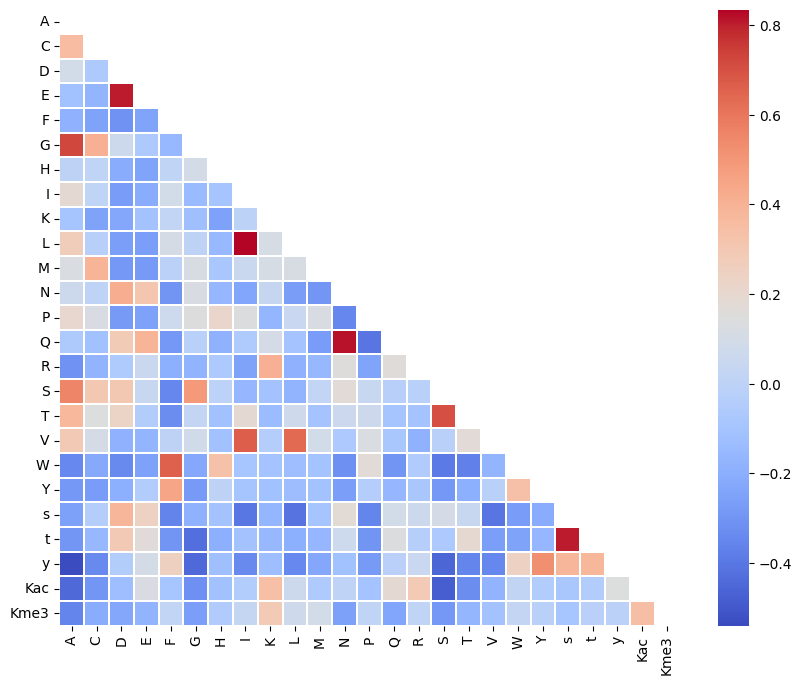

In [ ]:
plot_matrix(rdkit_corr)

## AUCDF

In [ ]:
#| export
def get_AUCDF(df,col, reverse=False,plot=True,xlabel='Rank of reported kinase'):
    
    "Plot CDF curve and get relative area under the curve"
    
    # sort col values as x values
    x_values = df[col].sort_values().values
    
    # get y_values evenly distributed from 0 to 1
    # y_values = np.arange(1, len(x_values) + 1) / len(x_values) # this method assumes equal distribution of each x value
    y_values = pd.Series(x_values).rank(method='average', pct=True).values # this method takes duplicates into account
    
    if reverse:
        y_values = 1 - y_values + y_values.min()  # Adjust for reverse while keeping the distribution's integrity
    # calculate the area under the curve using the trapezoidal rule
    area_under_curve = trapz(y_values, x_values)
    
    # calculate total area
    total_area = (x_values[-1] - x_values[0]) * (y_values[-1] - y_values[0])
    

    AUCDF = area_under_curve / total_area
    if reverse:
        AUCDF = -AUCDF
    
    if plot:
        # Create a figure and a primary axis
        fig, ax1 = plt.subplots(figsize=(7,5))
        
        # fontsize
        fontsize=17
        
        # Plot the histogram on the primary axis
        sns.histplot(x_values,bins=20,ax=ax1)
        ax1.set_xlabel(xlabel,fontsize=fontsize)
        ax1.set_ylabel('Substrates',color='darkblue',fontsize=fontsize)
        ax1.tick_params(axis='y', labelcolor='darkblue',labelsize=fontsize)
        ax1.tick_params(axis='x', labelcolor='black',labelsize=fontsize)
        ax1.set_xlim(min(x_values),max(x_values))

        # Create a secondary axis for the CDF
        ax2 = ax1.twinx()

        # Plot the CDF on the secondary axis
        # ax2.plot(bin_edges[:-1], cumulative_data, color='red', linestyle='-', linewidth=2.0)
        ax2.plot(x_values, y_values, color='darkred', linestyle='-', linewidth=2.0)
        if reverse:
            ax2.plot([max(x_values),0],[0, max(y_values)], 'k--')  # 'k--' is for a black dashed line
        else:
            ax2.plot([0, max(x_values)], [0, max(y_values)], 'k--')  # 'k--' is for a black dashed line

        ax2.set_ylabel('Probability', color='darkred',fontsize=fontsize,rotation=270,labelpad=18)
        if reverse:
            ax2.text(0.45, 0.3, f"AUCDF:{AUCDF.round(4)}", transform=plt.gca().transAxes, ha='right', va='bottom',fontsize=fontsize)
        else:
            ax2.text(0.95, 0.3, f"AUCDF:{AUCDF.round(4)}", transform=plt.gca().transAxes, ha='right', va='bottom',fontsize=fontsize)
        ax2.tick_params(axis='y', labelcolor='darkred',labelsize=fontsize)
        ax2.set_ylim(0, 1)  # Probabilities range from 0 to 1

        # Show the plot
        plt.title(f'{len(x_values)} kinase-substrate pairs',fontsize=fontsize)
        plt.show()
        
    return AUCDF

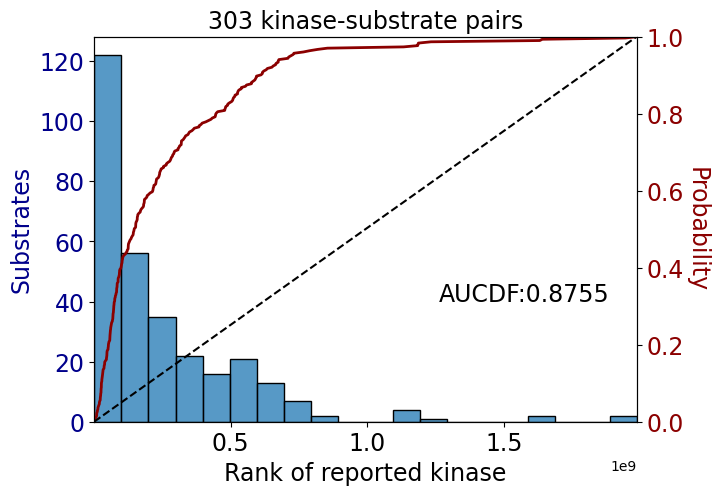

0.8754977337946649

In [ ]:
get_AUCDF(sorted_df,'values')

## Confusion matrix

In [ ]:
#| export
def plot_confusion_matrix(target, # pd.Series 
                          pred, # pd.Series
                          class_names:list=['0','1'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    "Plot the confusion matrix."
    
    cm = confusion_matrix(target, pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, cmap=cmap)  # Plot the heatmap
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(np.arange(len(class_names)) + 0.5, class_names)
    plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=0)

In [ ]:
target = info.MW<160
pred = info.pKa1>2.1

Normalized confusion matrix


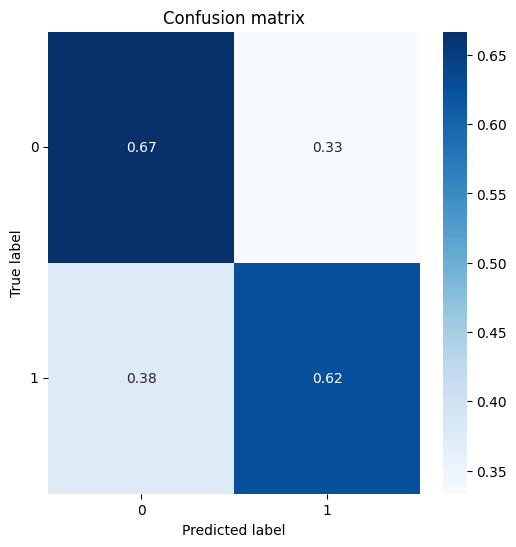

In [ ]:
plot_confusion_matrix(target,pred,normalize=True)

## End

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

In [ ]:
# #| export
# def get_logo2(full: pd.DataFrame, # a dataframe that contains the full matrix of a kinase, with index as amino acid, and columns as positions
#               title: str = 'logo', # title of the graph
#               ):
    
#     "Plot logo from a full freqency matrix of a kinase"
    
#     # get S,T,Y ratio
#     S_ratio,T_ratio,Y_ratio = full[0][['s','t','y']]/full[0][['s','t','y']].sum()
    
#     # drop position 0 
#     full = full.drop(columns=[0])
    
#     # identify the minimum value other than 0
#     min_val = full[full > 0].min().min()
    
#     # replace 0s with the identified minimum value
#     full = full.replace(0, min_val)
    
#     norm_p = full.T

#     # calculate ratio, use substraction
#     ratio =norm_p.apply(lambda r: r-r.median(),axis=1)
    
#     # calculate ratio based on previous method, divide values by median, followed by log2
#     # ratio =norm_p.apply(lambda r: r/r.median(),axis=1)
#     # ratio = np.log2(ratio)
    
#     # get the max value for a position
#     m = ratio.apply(lambda row: row[row > 0].sum(), axis=1).max()
    
#     # get the relative height of S,T,Y relative to the max value
#     new_row = pd.DataFrame({'S': S_ratio*m, 'T':T_ratio*m,'Y':Y_ratio*m}, index=[0]) 
    
#     # prepare the matrix for logomaker
#     ratio2 = pd.concat([ratio, new_row], ignore_index=False).fillna(0)

#     # logo_func(ratio2,title)
#     plot_logo_raw(ratio2.T,title=title)

# # get kinase-substrate dataset
# df = Data.get_ks_dataset()

# # get data for a specific kinase
# df_k = df.query('kinase == "DYRK2"')

# # get the full freq matrix
# _,full = get_freq(ks_k)

# # plot logo
# get_logo2(full,'DYRK2')